<a href="https://colab.research.google.com/github/aneesha215/Image-Segmentation-fastai/blob/master/ImageSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

In [0]:
from fastai.callbacks.hooks import *

In [0]:
from fastai.utils.mem import *

In [0]:
path=untar_data(URLs.CAMVID)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl=path/'labels'
path_img=path/'images'

In [0]:
fnames=get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03930.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008550.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03090.png')]

In [0]:
lblnames=get_image_files(path_lbl)
lblnames[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02220_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01230_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02550_P.png')]

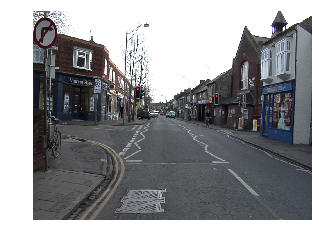

In [0]:
imgf=fnames[0]
img=open_image(imgf)
img.show(figsize=(5,5))

In [0]:
get_y_fn= lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

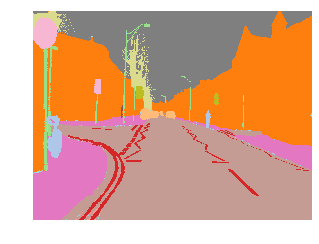

In [0]:
mask = open_mask(get_y_fn(imgf))
mask.show(figsize=(5,5),alpha=1)

In [0]:
src_size=np.array(mask.shape[1:])
mask.data,src_size

(tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]), array([720, 960]))

In [0]:
codes=np.loadtxt(path/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size=src_size//2


free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

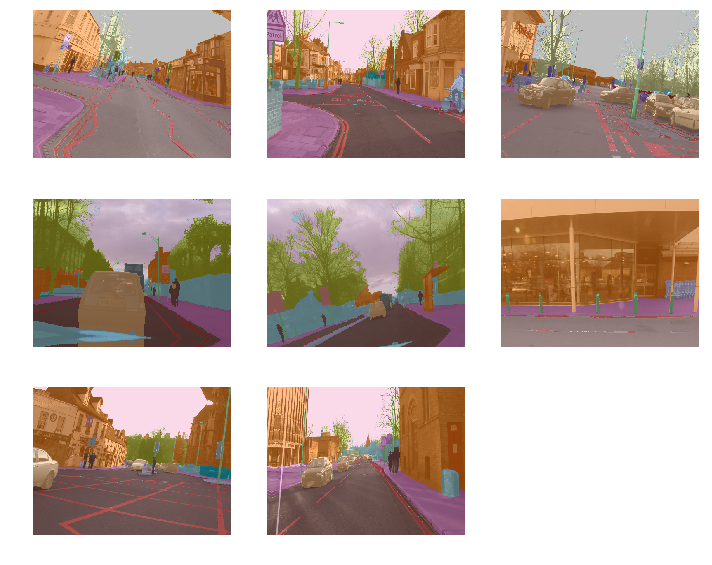

In [0]:
data.show_batch(9,figsize=(10,8))

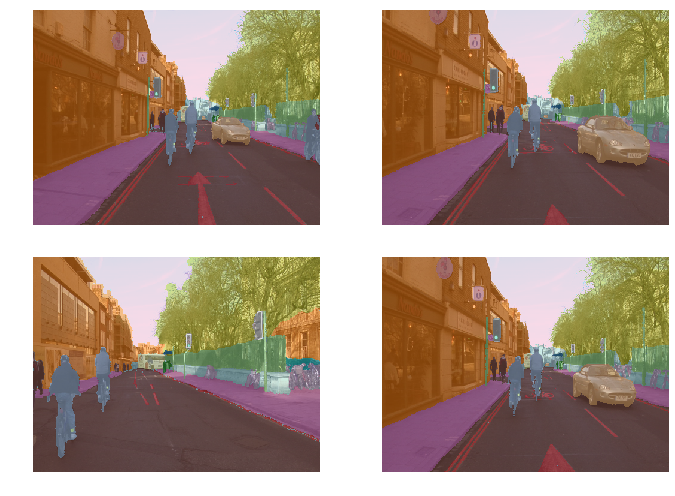

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


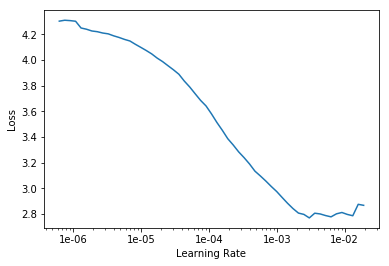

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.896700,0.831957,0.813024,01:34
1,0.824400,0.770822,0.821364,01:34
2,0.734983,0.657728,0.838434,01:34
3,0.678370,0.585304,0.847732,01:34
4,0.603187,0.529978,0.851551,01:34
5,0.571180,0.530472,0.845789,01:34
6,0.543263,0.515946,0.861012,01:34
7,0.502993,0.410281,0.872652,01:34
8,0.448006,0.359264,0.890204,01:34
9,0.403262,0.325192,0.905307,01:34


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

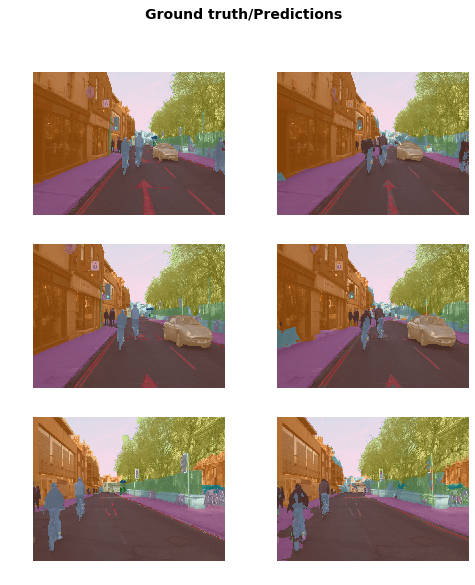

In [0]:
learn.show_results(rows=3,figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


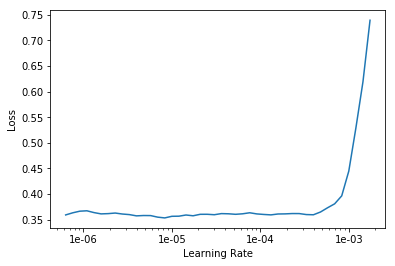

In [0]:
learn.recorder.plot()

In [0]:
lrs=slice(9e-5,5e-4)

In [0]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.349889,0.317845,0.906933,01:38
1,0.346892,0.331972,0.902684,01:38
2,0.339842,0.328302,0.902934,01:38
3,0.368204,0.350301,0.900096,01:38
4,0.370512,0.344513,0.900042,01:38
5,0.373209,0.359333,0.899894,01:37
6,0.375057,0.307048,0.915525,01:37
7,0.396281,0.408873,0.881648,01:37
8,0.391038,0.360274,0.898720,01:37
9,0.365532,0.290481,0.918850,01:37


In [0]:
learn.save('stage-2')

In [0]:
lrs=slice(lr/400,lr/4)

In [0]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [0]:
learn.save('stage-2')

In [0]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 11293MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


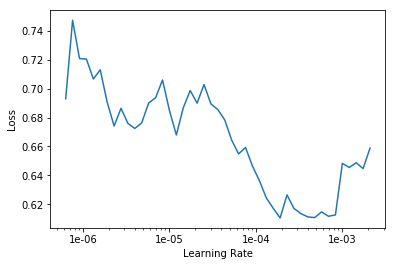

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-4

In [0]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.448006,0.326396,0.911310,06:10
1,0.440465,0.336211,0.910920,06:11
2,0.352205,0.338478,0.909976,06:11
3,0.353247,0.298996,0.913778,06:10
4,0.310025,0.331752,0.912743,06:10
5,0.305659,0.299051,0.917235,06:10
6,0.297452,0.310524,0.908827,06:10
7,0.306243,0.273312,0.925468,06:10
8,0.242346,0.308784,0.915059,06:10
9,0.220979,0.276331,0.923543,06:10


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.235068,0.286637,0.922051,06:28
1,0.220060,0.278810,0.922563,06:28
2,0.198288,0.268795,0.926510,06:28
3,0.222692,0.270757,0.926196,06:28
4,0.195763,0.266498,0.926477,06:28
5,0.195929,0.286711,0.923628,06:28
6,0.205434,0.269767,0.927295,06:28
7,0.183909,0.265778,0.928463,06:28
8,0.179371,0.275710,0.925463,06:28
9,0.189344,0.267176,0.927905,06:28


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

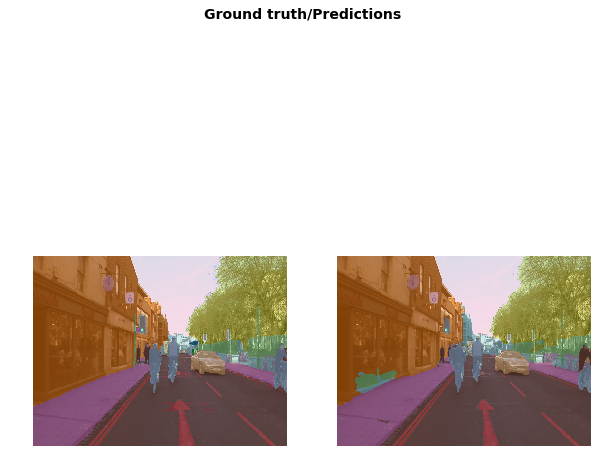

In [0]:
learn.show_results(rows=3,figsize=(10,10))

In [0]:
learn = unet_learner(data, models.resnet34)


In [0]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [0]:
learn.export()

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels')]

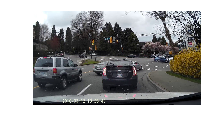

In [0]:
img.show()

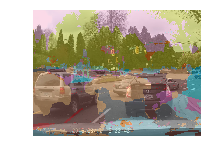

In [0]:
img.show(y=learn.predict(img)[0])